# Linear Regression Implementation

The following implementation of linear regression has support for both single and multiple features. The implementation is based on the normal equation method. The normal equation method is a closed-form solution to linear regression. It is computationally expensive when the number of features is large, but it is efficient when the number of features is small.

In addition, the implementation includes a gradient descent method. The gradient descent method is an iterative optimization algorithm that is computationally efficient when the number of features is large.

There is also support for different optimizers such as momentum, ADAM, and RMSprop optimization. 

Finally, there is support for batch processing the data.

Auxillary functions include predict, r^2 score, mean squared error, and mean absolute error.

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split

# define optimizer enum for optimizer selection
class Optimizer:
    MOMENTUM = 1
    RMSPROP = 2
    ADAM = 3

# define regularizer enum for regularizer selection
class Regularizer:
    L1 = 1
    L2 = 2
    ELASTIC_NET = 3

class MultiVariateLinearRegression():
    def __init__(self, learning_rate=0.01, epochs=10000):
        # weight update parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None

        # optimizer parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # early stopping parameters
        self.convergence_threshold = 1e-4
        self.convergence_epochs = 5

        # regularization parameters
        self.lambda_ = 0.01
        self.r = 0.5


    def fit(self, X, y, closed_form=False, add_bias=True, optimizer=None, regularizer=None):
        # add a column of ones to X for the bias term
        X_bias = X
        if add_bias:
            X_bias = np.c_[X, np.ones(X.shape[0])]

        # chooses between closed and gradient descent solution
        if closed_form:
            self.closed_form(X_bias, y, regularizer)
        else:
            self.gradient_descent(X_bias, y, optimizer, regularizer)

    # implements closed form solution for linear regression, with regularization
    def closed_form(self, X, y, regularizer=None):
        if regularizer == Regularizer.L1 or regularizer == Regularizer.ELASTIC_NET:
            raise NotImplementedError("L1 and Elastic Net regularization not supported with closed form solution")
        elif regularizer == Regularizer.L2:
            self.weights = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + self.lambda_ * np.eye(X.shape[1])), X.T), y)
        else:
            self.weights = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

    def gradient_descent(self, X, y, optimizer=None, regularizer=None):
        self.weights = np.zeros(X.shape[1])
        v_dw = np.zeros(X.shape[1])
        s_dw = np.zeros(X.shape[1])
        t = 0
        prev_val_loss = float('inf')
        no_improvement_epochs = 0

        # split into train and validation set
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

        for _ in range(self.epochs):
            dw = None

            # computes the gradient with respect to the loss function, with regularization
            if regularizer == Regularizer.L1:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.weights) - y_train) / X_train.shape[0] + self.lambda_ * np.sign(self.weights)
            elif regularizer == Regularizer.L2:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.weights) - y_train) / X_train.shape[0] + 2 * self.lambda_ * self.weights
            elif regularizer == Regularizer.ELASTIC_NET:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.weights) - y_train) / X_train.shape[0] + self.lambda_ * self.r * np.sign(self.weights) + self.lambda_ * (1 - self.r) * self.weights
            else:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.weights) - y_train) / X_train.shape[0]

            # caluclates the intermedate values for the optimizer
            if optimizer == Optimizer.MOMENTUM:
                v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                self.weights -= self.learning_rate * v_dw
            elif optimizer == Optimizer.RMSPROP:
                s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                self.weights -= self.learning_rate * dw / (np.sqrt(s_dw) + self.epsilon)
            elif optimizer == Optimizer.ADAM:
                t += 1
                v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                v_dw_corrected = v_dw / (1 - self.beta1 ** (t+1))
                s_dw_corrected = s_dw / (1 - self.beta2 ** (t+1))
                self.weights -= self.learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + self.epsilon)
            else:
                self.weights -= self.learning_rate * dw

            # compute validation loss inline
            pred = np.dot(X_val, self.weights)
            val_loss = np.sum((y_val - pred) ** 2) / X_val.shape[0]

            # early stopping
            if prev_val_loss - val_loss < self.convergence_threshold:
                no_improvement_epochs += 1
                if no_improvement_epochs >= self.convergence_epochs:
                    print(f"No improvement for {self.convergence_epochs} epochs. Stopping training.")
                    break
            else:
                no_improvement_epochs = 0

            prev_val_loss = val_loss

    def batch_fit(self, X, y, batch_size=32, add_bias=True, optimizer=None, regularizer=None):
        X_bias = X
        if add_bias:
            X_bias = np.c_[X, np.ones(X.shape[0])]

        # initialize weights, optimizer parameters, and early stopping parameters
        self.weights = np.zeros(X_bias.shape[1])
        v_dw = np.zeros(X.shape[1])
        s_dw = np.zeros(X.shape[1])
        t = 0
        prev_val_loss = float('inf')
        no_improvement_epochs = 0

        # generaet a validation set
        X_train, X_val, y_train, y_val = train_test_split(X_bias, y, test_size=0.2)

        # iterate over the number of epochs
        for _ in range(self.epochs):
            # iterate over the batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                dw = None

                # computes the gradient with respect to the loss function, with regularization
                if regularizer == Regularizer.L1:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.weights) - y_batch) / X_batch.shape[0] + self.lambda_ * np.sign(self.weights)
                elif regularizer == Regularizer.L2:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.weights) - y_batch) / X_batch.shape[0] + 2 * self.lambda_ * self.weights
                elif regularizer == Regularizer.ELASTIC_NET:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.weights) - y_batch) / X_batch.shape[0] + self.lambda_ * self.r * np.sign(self.weights) + self.lambda_ * (1 - self.r) * self.weights
                else:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.weights) - y_batch) / X_batch.shape[0]

                # caluclates the intermedate values for the optimizer
                if optimizer == Optimizer.MOMENTUM:
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    self.weights -= self.learning_rate * v_dw
                elif optimizer == Optimizer.RMSPROP:
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    self.weights -= self.learning_rate * dw / (np.sqrt(s_dw) + self.epsilon)
                elif optimizer == Optimizer.ADAM:
                    t += 1
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    v_dw_corrected = v_dw / (1 - self.beta1 ** (t+1))
                    s_dw_corrected = s_dw / (1 - self.beta2 ** (t+1))
                    self.weights -= self.learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + self.epsilon)
                else:
                    self.weights -= self.learning_rate * dw

            # compute validation loss inline

            pred = np.dot(X_val, self.weights)
            val_loss = np.sum((y_val - pred) ** 2) / X_val.shape[0]

            # early stopping
            if prev_val_loss - val_loss < self.convergence_threshold:
                no_improvement_epochs += 1
                if no_improvement_epochs >= self.convergence_epochs:
                    print(f"No improvement for {self.convergence_epochs} epochs. Stopping training.")
                    break
            else:
                no_improvement_epochs = 0

            prev_val_loss = val_loss

    # predict the output given the input
    def predict(self, X, add_bias=True):
        if add_bias:
            return np.dot(np.c_[X, np.ones(X.shape[0])], self.weights)
        else:
            return np.dot(X, self.weights)

    # compute the R^2 score
    def compute_r2(self, X, y, add_bias=True):
        y_pred = self.predict(X, add_bias)
        return 1 - (np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2))
    
    # compute the mean squared error
    def compute_mse(self, X, y, add_bias=True):
        y_pred = self.predict(X, add_bias)
        return np.sum((y - y_pred) ** 2) / X.shape[0]
    
    # compute the mean absolute error
    def compute_mae(self, X, y, add_bias=True):
        y_pred = self.predict(X, add_bias)
        return np.sum(np.abs(y - y_pred)) / X.shape[0]

# Testing linear regression

The following code segment tests the linear regression model on a generated dataset. The base model is y = 2x_1 + 3x_2 + 4x_3 + 3. There is some noise added to the model.

No improvement for 5 epochs. Stopping training.
[2.61831509 2.96019771 3.37307786 3.00918096]
0.07219908144247453
No improvement for 5 epochs. Stopping training.
[1.93073268 2.90463725 3.89138067 3.13999926]
0.01184092142990806
No improvement for 5 epochs. Stopping training.
[1.87973643 3.0665204 ]
0.01108455012085914


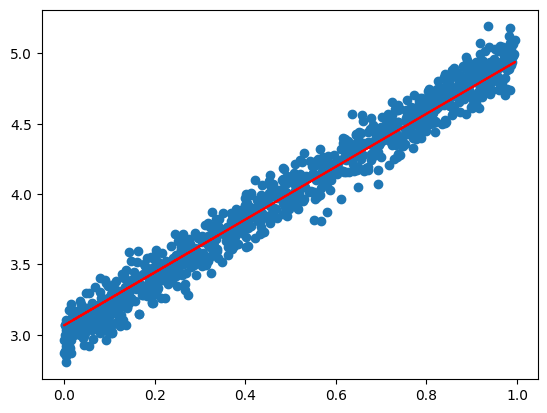

No improvement for 5 epochs. Stopping training.
[2.612307   2.98134983 3.27796953 3.02071329]
0.08276741078454805
No improvement for 5 epochs. Stopping training.
[2.6554943  3.02403899 3.32408993 2.99601295]
0.07945631483907277


In [45]:
# generate a dataset using y = 2x_1 + 3x_2 + 4x_3 + 3 with noise
X = np.random.rand(1000, 3)
y = 2 * X[:, 0] + 3 * X[:, 1] + 4 * X[:, 2] + 3 + np.random.normal(0, 0.1, 1000)

model = MultiVariateLinearRegression(epochs=1000000000000)

model.fit(X, y, closed_form=False, optimizer=Optimizer.ADAM)

print(model.weights)

print(model.compute_mse(X, y))

# now batch fit
model.batch_fit(X, y, batch_size=32)

print(model.weights)

print(model.compute_mse(X, y))

# generate a simple line equation y = 2x + 3 with noise
X = np.random.rand(1000, 1)
y = 2 * X[:, 0] + 3 + np.random.normal(0, 0.1, 1000)

model = MultiVariateLinearRegression()

model.batch_fit(X, y)

print(model.weights)

print(model.compute_mse(X, y))

# plot the data and the line
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], y)
plt.plot(X[:, 0], model.predict(X), color='red')
plt.show()

# compare regularized vs non-regularized
X = np.random.rand(1000, 3)
y = 2 * X[:, 0] + 3 * X[:, 1] + 4 * X[:, 2] + 3 + np.random.normal(0, 0.1, 1000)

model = MultiVariateLinearRegression(epochs=1000000000000)

model.fit(X, y, closed_form=False, optimizer=Optimizer.ADAM, regularizer=Regularizer.L2)

print(model.weights)

print(model.compute_mse(X, y))

model = MultiVariateLinearRegression(epochs=1000000000000)

model.fit(X, y, closed_form=False, optimizer=Optimizer.ADAM)

print(model.weights)

print(model.compute_mse(X, y))

# Multivariate Linear Regression

The following implementation of logistic regression has support for both single and multiple features. The implementation is based on the normal equation method. The normal equation method is a closed-form solution to linear regression. It is computationally expensive when the number of features is large, but it is efficient when the number of features is small.

In addition, the implementation includes a gradient descent method. The gradient descent method is an iterative optimization algorithm that is computationally efficient when the number of features is large.

There is also support for different optimizers such as momentum, ADAM, and RMSprop optimization. 

Finally, there is support for batch processing the data.

Auxillary functions include predict, accuracy, and log loss.

In [46]:
# Note: if you choose to use gradient descent, you MUST normalize the X data before fitting the model OR choose an EXTREMELY small learning rate (otherwise will face vanishing/exploding gradients and get nan model parameters)
# ALSO, when you use batching, make sure to shuffle the data
class MultiVariateLogRegression():
    def __init__(self, learning_rate=0.1, epochs=100):
        # weight update parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None

        # optimizer parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # early stopping parameters
        self.convergence_threshold = 1e-4
        self.convergence_epochs = 5

        # regularization parameters
        self.lambda_ = 0.01
        self.r = 0.5

    def fit(self, X, y, optimizer=None):
        # add a column of ones to X for the bias term
        X_bias = np.c_[np.ones(X.shape[0]),X]

        self.gradient_descent(X_bias, y, optimizer)

    def gradient_descent(self, X, y, optimizer=None, regularizer=None):
        self.weights = np.zeros(X.shape[1])
        v_dw = np.zeros(X.shape[1])
        s_dw = np.zeros(X.shape[1])

        t = 0
        prev_val_loss = float('inf')
        no_improvement_epochs = 0

        # split into train and validation set
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

        # iterate over the number of epochs
        for _ in range(self.epochs):

            # computes the gradient with respect to the loss function, with regularization
            y_pred = self.sigmoid(np.dot(X_train, self.weights))
            dw = None
            if regularizer == Regularizer.L1:
                dw = np.dot(X_train.T, y_pred - y_train)/X_train.shape[0] + self.lambda_ * np.sign(self.weights)
            elif regularizer == Regularizer.L2:
                dw = np.dot(X_train.T, y_pred - y_train)/X_train.shape[0] + 2 * self.lambda_ * self.weights
            elif regularizer == Regularizer.ELASTIC_NET:
                dw = np.dot(X_train.T, y_pred - y_train)/X_train.shape[0] + self.lambda_ * self.r * np.sign(self.weights) + self.lambda_ * (1 - self.r) * self.weights
            else:
                dw = np.dot(X_train.T, y_pred - y_train)/X_train.shape[0]


            # caluclates the intermedate values for the optimizer
            if optimizer == Optimizer.MOMENTUM:
                v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                self.weights -= self.learning_rate * v_dw
            elif optimizer == Optimizer.RMSPROP:
                s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                self.weights -= self.learning_rate * dw / (np.sqrt(s_dw) + self.epsilon)
            elif optimizer == Optimizer.ADAM:
                t += 1
                v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                v_dw_corrected = v_dw / (1 - self.beta1 ** (t+1))
                s_dw_corrected = s_dw / (1 - self.beta2 ** (t+1))
                self.weights -= self.learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + self.epsilon)
            else:
                self.weights -= self.learning_rate * dw
            
            # compute validation loss inline
            y_pred = self.sigmoid(np.dot(X_val, self.weights))
            val_loss = -np.sum(y_val * np.log(y_pred) + (1 - y_val) * np.log(1 - y_pred)) / X_val.shape[0]

            # early stopping
            if prev_val_loss - val_loss < self.convergence_threshold:
                no_improvement_epochs += 1
                if no_improvement_epochs >= self.convergence_epochs:
                    print(f"No improvement for {self.convergence_epochs} epochs. Stopping training.")
                    break
            else:
                no_improvement_epochs = 0

            prev_val_loss = val_loss
            

    def batch_fit(self, X, y, batch_size=32, optimizer=None, regularizer=None):
        X_bias = np.c_[np.ones(X.shape[0]),X]

        # initialize weights, optimizer parameters, and early stopping parameters
        self.weights = np.zeros(X_bias.shape[1])

        v_dw = np.zeros(X.shape[1])
        s_dw = np.zeros(X.shape[1])
        t = 0
        prev_val_loss = float('inf')
        no_improvement_epochs = 0

        # generate a validation set
        X_train, X_val, y_train, y_val = train_test_split(X_bias, y, test_size=0.2)

        # iterate over the number of epochs
        for _ in range(self.epochs):
            # iterate over the batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                y_pred = self.sigmoid(np.dot(X_batch, self.weights))

                # computes the gradient with respect to the loss function, with regularization
                dw = None
                if regularizer == Regularizer.L1:
                    dw = np.dot(X_batch.T, y_pred - y_batch)/X_batch.shape[0] + self.lambda_ * np.sign(self.weights)
                elif regularizer == Regularizer.L2:
                    dw = np.dot(X_batch.T, y_pred - y_batch)/X_batch.shape[0] + 2 * self.lambda_ * self.weights
                elif regularizer == Regularizer.ELASTIC_NET:
                    dw = np.dot(X_batch.T, y_pred - y_batch)/X_batch.shape[0] + self.lambda_ * self.r * np.sign(self.weights) + self.lambda_ * (1 - self.r) * self.weights
                else:
                    dw = np.dot(X_batch.T, y_pred - y_batch)
                
                # caluclates the intermedate values for the optimizer
                if optimizer == Optimizer.MOMENTUM:
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    self.weights -= self.learning_rate * v_dw
                elif optimizer == Optimizer.RMSPROP:
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    self.weights -= self.learning_rate * dw / (np.sqrt(s_dw) + self.epsilon)
                elif optimizer == Optimizer.ADAM:
                    t += 1
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    v_dw_corrected = v_dw / (1 - self.beta1 ** (t+1))
                    s_dw_corrected = s_dw / (1 - self.beta2 ** (t+1))
                    self.weights -= self.learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + self.epsilon)
                else:
                    self.weights -= self.learning_rate * dw


            # compute validation loss inline
            y_pred = self.sigmoid(np.dot(X_val, self.weights))
            val_loss = -np.sum(y_val * np.log(y_pred) + (1 - y_val) * np.log(1 - y_pred)) / X_val.shape[0]

            # early stopping
            if prev_val_loss - val_loss < self.convergence_threshold:
                no_improvement_epochs += 1
                if no_improvement_epochs >= self.convergence_epochs:
                    print(f"No improvement for {self.convergence_epochs} epochs. Stopping training.")
                    break
            else:
                no_improvement_epochs = 0

            prev_val_loss = val_loss

    # implement the sigmoid function
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # predict the output given the input
    def predict(self, X):
        X_bias = np.c_[np.ones(X.shape[0]),X]
        return self.sigmoid(np.dot(X_bias, self.weights))
    
    # compute the accuracy
    def compute_accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.sum(np.round(y_pred) == y) / X.shape[0]
    
    # compute the log loss
    def compute_log_loss(self, X, y):
        y_pred = self.predict(X)
        return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / X.shape[0]

# Testing Logistic Regression

The following code segment tests the logistic regression model on a generated dataset. Random data points are generated and the data is split halfway to create 2 classes. 

Finally, the logistic curve is plotted against the input data.

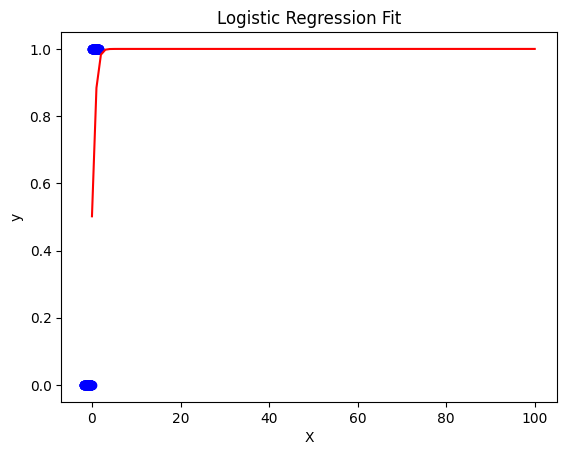

0.96
No improvement for 5 epochs. Stopping training.
1.0


In [47]:
import matplotlib.pyplot as plt

# Generate dataset
X_class1 = np.random.uniform(0, 50, 50)
X_class2 = np.random.uniform(51, 100, 50)
X = np.concatenate((X_class1, X_class2))
y = np.concatenate((np.zeros(50), np.ones(50)))

# normalize the data
X = (X - np.mean(X)) / np.std(X)

# Reshape X for compatibility with the model
X = X.reshape(-1, 1)

# Fit the logistic regression model
model = MultiVariateLogRegression()
model.fit(X, y)

# Plot the data points
plt.scatter(X, y, color='blue')

# Plot the best-fit line using model weights
x_values = np.linspace(0, 100, 100)
y_values = model.predict(x_values)
plt.plot(x_values, y_values, color='red')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Logistic Regression Fit')
plt.show()

print(model.compute_accuracy(X, y))


# generate multivariate logistic dataset, first half of dataset is between values of 0 and 50, the second half is between 51 and 100
X_class1 = np.random.uniform(0, 50, (1000, 2))
X_class2 = np.random.uniform(51, 100, (1000, 2))

X = np.concatenate((X_class1, X_class2))

y = np.concatenate((np.zeros(1000), np.ones(1000)))

# normalize the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# shuffle the data
perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

model = MultiVariateLogRegression()

model.batch_fit(X, y)

print(model.compute_accuracy(X, y))

# Polynomial Regression

The following implementation of polynomial regression has support for both single and multiple features. The implementation is based on the normal equation method. The normal equation method is a closed-form solution to linear regression. It is computationally expensive when the number of features is large, but it is efficient when the number of features is small.

In addition, the implementation includes a gradient descent method. The gradient descent method is an iterative optimization algorithm that is computationally efficient when the number of features is large.

Polynomial features are generated using the sklearn PolynomialFeatures class.

There is also support for different optimizers such as momentum, ADAM, and RMSprop optimization. 

Finally, there is support for batch processing the data.

Auxillary functions include predict, r^2 score, mean squared error, and mean absolute error.

In [48]:
from sklearn.preprocessing import PolynomialFeatures

# implement polynomial feature generation
def generate_polynomial_features(degree, X):
        poly = PolynomialFeatures(degree=degree)
        return poly.fit_transform(X)

class PolynomialRegression:
    def __init__(self, degree=2):
        # degree of the polynomial
        self.degree = degree
        self.poly = PolynomialFeatures(degree=degree)
        self.coef_ = None

        # optimizer parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # learning rate and epochs
        self.learning_rate = 0.01
        self.epochs = 1000

        # early stopping parameters
        self.convergence_threshold = 1e-4
        self.convergence_epochs = 5

        # regularization parameters
        self.lambda_ = 0.01
        self.r = 0.5

    def fit(self, X, y, regularizer=None):
        X_poly = self.poly.fit_transform(X)

        # chooses between closed and gradient descent solution
        if regularizer == Regularizer.L1 or regularizer == Regularizer.ELASTIC_NET:
            raise NotImplementedError("L1 and Elastic Net regularization not supported with closed form solution")
        elif regularizer == Regularizer.L2:
            self.coef_ = np.dot(np.dot(np.linalg.inv(np.dot(X_poly.T, X_poly) + self.lambda_ * np.eye(X_poly.shape[1])), X_poly.T), y)
        else:
            self.coef_ = np.linalg.inv(X_poly.T @ X_poly) @ X_poly.T @ y

    def fit_gradient_descent(self, X, y, optimizer=None, regularizer=None):
        X_poly = self.poly.fit_transform(X)
        self.coef_ = np.zeros(X_poly.shape[1])
        v_dw = np.zeros(X_poly.shape[1])
        s_dw = np.zeros(X_poly.shape[1])
        t = 0
        prev_val_loss = float('inf')
        no_improvement_epochs = 0

        # split into train and validation set
        X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.2)

        # iterate over the number of epochs
        for _ in range(self.epochs):

            # computes the gradient with respect to the loss function, with regularization
            dw = None
            if regularizer == Regularizer.L1:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.coef_) - y_train) / X_train.shape[0] + self.lambda_ * np.sign(self.coef_)
            elif regularizer == Regularizer.L2:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.coef_) - y_train) / X_train.shape[0] + 2 * self.lambda_ * self.coef_
            elif regularizer == Regularizer.ELASTIC_NET:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.coef_) - y_train) / X_train.shape[0] + self.lambda_ * self.r * np.sign(self.coef_) + self.lambda_ * (1 - self.r) * self.coef_
            else:
                dw = 2 * np.dot(X_train.T, np.dot(X_train, self.coef_) - y_train) / X_train.shape[0]


            # caluclates the intermedate values for the optimizer
            if optimizer == Optimizer.MOMENTUM:
                v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                self.coef_ -= self.learning_rate * v_dw

            elif optimizer == Optimizer.RMSPROP:
                s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                self.coef_ -= self.learning_rate * dw / (np.sqrt(s_dw) + self.epsilon)

            elif optimizer == Optimizer.ADAM:
                t += 1
                v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                v_dw_corrected = v_dw / (1 - self.beta1 ** (t+1))
                s_dw_corrected = s_dw / (1 - self.beta2 ** (t+1))
                self.coef_ -= self.learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + self.epsilon)

            else:
                self.coef_ -= self.learning_rate * dw

            # compute validation loss inline
            pred = np.dot(X_val, self.coef_)
            val_loss = np.sum((y_val - pred) ** 2) / X_val.shape[0]

            # early stopping
            if prev_val_loss - val_loss < self.convergence_threshold:
                no_improvement_epochs += 1
                if no_improvement_epochs >= self.convergence_epochs:
                    print(f"No improvement for {self.convergence_epochs} epochs. Stopping training.")
                    break
            else:
                no_improvement_epochs = 0

            prev_val_loss = val_loss

    def batch_fit(self, X, y, batch_size=32, optimizer=None, regularizer=None):
        X_poly = self.poly.fit_transform(X)

        # initialize weights, optimizer parameters, and early stopping parameters
        self.coef_ = np.zeros(X_poly.shape[1])
        v_dw = np.zeros(X_poly.shape[1])
        s_dw = np.zeros(X_poly.shape[1])
        t = 0
        prev_val_loss = float('inf')
        no_improvement_epochs = 0

        # generate a validation set
        X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.2)

        # iterate over the number of epochs
        for _ in range(self.epochs):
            # iterate over the batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # computes the gradient with respect to the loss function, with regularization
                dw = None
                if regularizer == Regularizer.L1:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.coef_) - y_batch) / X_batch.shape[0] + self.lambda_ * np.sign(self.coef_)
                elif regularizer == Regularizer.L2:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.coef_) - y_batch) / X_batch.shape[0] + 2 * self.lambda_ * self.coef_
                elif regularizer == Regularizer.ELASTIC_NET:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.coef_) - y_batch) / X_batch.shape[0] + self.lambda_ * self.r * np.sign(self.coef_) + self.lambda_ * (1 - self.r) * self.coef_
                else:
                    dw = 2 * np.dot(X_batch.T, np.dot(X_batch, self.coef_) - y_batch) / X_batch.shape[0]

                # caluclates the intermedate values for the optimizer
                if optimizer == Optimizer.MOMENTUM:
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    self.coef_ -= self.learning_rate * v_dw

                elif optimizer == Optimizer.RMSPROP:
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    self.coef_ -= self.learning_rate * dw / (np.sqrt(s_dw) + self.epsilon)

                elif optimizer == Optimizer.ADAM:
                    t += 1
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    v_dw_corrected = v_dw / (1 - self.beta1 ** (t+1))
                    s_dw_corrected = s_dw / (1 - self.beta2 ** (t+1))
                    self.coef_ -= self.learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + self.epsilon)

                else:
                    self.coef_ -= self.learning_rate * dw

            # compute validation loss inline
            pred = np.dot(X_val, self.coef_)
            val_loss = np.sum((y_val - pred) ** 2) / X_val.shape[0]

            # early stopping
            if prev_val_loss - val_loss < self.convergence_threshold:
                no_improvement_epochs += 1
                if no_improvement_epochs >= self.convergence_epochs:
                    print(f"No improvement for {self.convergence_epochs} epochs. Stopping training.")
                    break
            else:
                no_improvement_epochs = 0

            prev_val_loss = val_loss

    # predict the output given the input
    def predict(self, X):
        X_poly = self.poly.fit_transform(X)
        return X_poly @ self.coef_
    
    # compute the R^2 score
    def score(self, X, y):
        y_pred = self.predict(X)
        return 1 - ((y - y_pred) ** 2).sum() / ((y - y.mean()) ** 2).sum()
    
    # compute the mean squared error
    def mse(self, X, y):
        y_pred = self.predict(X)
        return ((y - y_pred) ** 2).mean()
    
    # compute the mean absolute error
    def mae(self, X, y):
        y_pred = self.predict(X)
        return np.abs(y - y_pred).mean()

# Testing Polynomial Regression

The following code segment tests the polynomial regression model on a generated dataset. Polynomial functions are the basis for each model's input. However, some noise is added onto each dataset. Furthermore, more complex polynomial functions are tested further down, such as a 5th and 20th degree polynomial.



No improvement for 5 epochs. Stopping training.
[2.49010153 1.00518094 1.33496733 1.68219924 0.63972506 0.49939174
 0.67451037 1.00906344 0.86340163 1.37931622]
0.10231568095780073
No improvement for 5 epochs. Stopping training.
[2.63502141 1.34426658 0.93023939]
0.024761820259824863


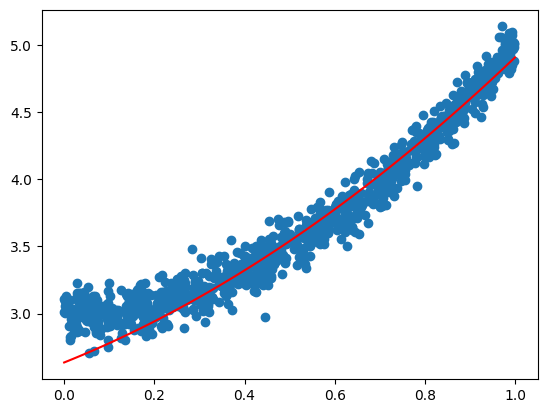

No improvement for 5 epochs. Stopping training.
[-1.16618683 -2.97001035 -2.32743099  3.419786    3.34937511  3.19044265]
0.15990563721961754


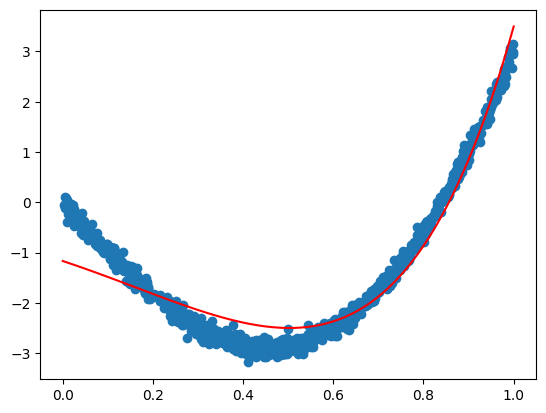

[-7.69542605e-03 -9.79261953e+00 -1.13900743e+00  2.54925186e+01
 -1.54248075e+01  3.87414413e+00]
0.010574009552088122


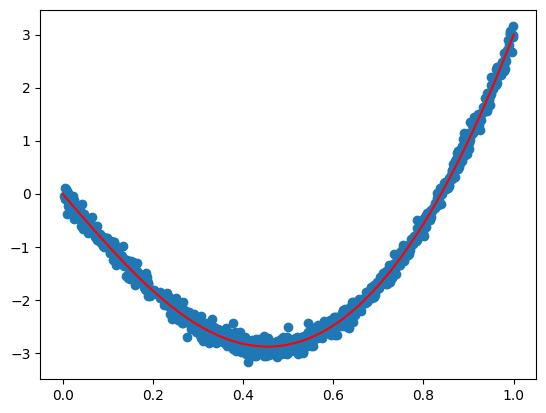

No improvement for 5 epochs. Stopping training.
[ 0.48766707 -7.06648337 -4.17187127 11.19941556 -8.31481893 12.79350179]
0.2967245858331655


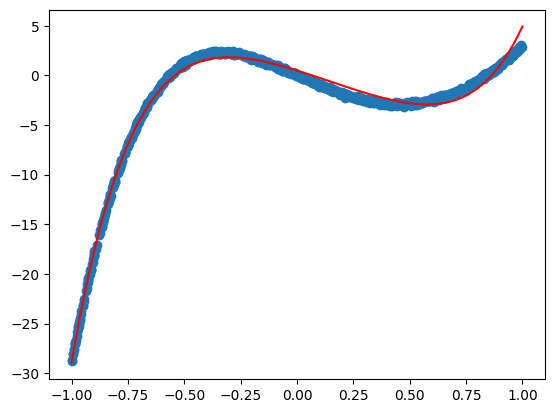

No improvement for 5 epochs. Stopping training.
[ 1.25530481e-02 -9.64671292e+00 -6.71543957e-02  2.14278127e+01
 -1.29098291e+01  4.40713125e+00]
0.012800272221148584


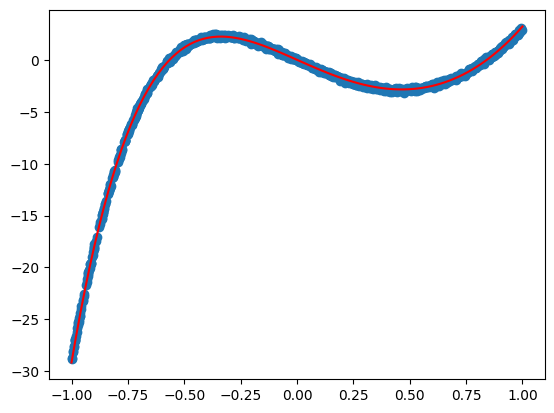

In [49]:
# generate a dataset using y = 2x_1^2 + 3x_2^2 + 4x_3^2 + 3 with noise
X = np.random.rand(1000, 3)
y = 2 * X[:, 0] ** 2 + 3 * X[:, 1] ** 2 + 4 * X[:, 2] ** 2 + 3 + np.random.normal(0, 0.1, 1000)

model = PolynomialRegression(degree=2)

model.fit_gradient_descent(X, y)

print(model.coef_)

print(model.mse(X, y))

# generate a simple quadratic equation y = 2x^2 + 3 with noise
X = np.random.rand(1000, 1)
y = 2 * X[:, 0] ** 2 + 3 + np.random.normal(0, 0.1, 1000)

model = PolynomialRegression(degree=2)

model.fit_gradient_descent(X, y)

print(model.coef_)
print(model.mse(X, y))

# plot the data and the line
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], y)

x_values = np.linspace(0, 1, 100)

y_values = model.predict(x_values.reshape(-1, 1))

plt.plot(x_values, y_values, color='red')

plt.show()

# generate a polynomial y = 3x^{5}-13x^{4}+23x^{3}-10x

X = np.random.rand(1000, 1)
y = 3 * X[:, 0] ** 5 - 13 * X[:, 0] ** 4 + 23 * X[:, 0] ** 3 - 10 * X[:, 0] + np.random.normal(0, 0.1, 1000)

model = PolynomialRegression(degree=5)

model.epochs = 1000000

model.fit_gradient_descent(X, y, optimizer=Optimizer.ADAM)

print(model.coef_)

print(model.mse(X, y))

# plot the data and the line

plt.scatter(X[:, 0], y)

x_values = np.linspace(0, 1, 100)

y_values = model.predict(x_values.reshape(-1, 1))

plt.plot(x_values, y_values, color='red')

plt.show()

# repeat with a closed form solution
model = PolynomialRegression(degree=5)

model.fit(X, y)

print(model.coef_)

print(model.mse(X, y))

# plot the data and the line

plt.scatter(X[:, 0], y)

x_values = np.linspace(0, 1, 100)

y_values = model.predict(x_values.reshape(-1, 1))

plt.plot(x_values, y_values, color='red')

plt.show()

# repeat with x values between -100 and 100
X = np.random.uniform(-1, 1, (1000, 1))

# y = 3x^{5}-13x^{4}+23x^{3}-10x
y = 3 * X[:, 0] ** 5 - 13 * X[:, 0] ** 4 + 23 * X[:, 0] ** 3 - 10 * X[:, 0] + np.random.normal(0, 0.1, 1000)

model = PolynomialRegression(degree=5)

model.epochs = 1000000

model.fit_gradient_descent(X, y, optimizer=Optimizer.ADAM)

print(model.coef_)
print(model.mse(X, y))

# plot the data and the line

plt.scatter(X[:, 0], y)

x_values = np.linspace(-1, 1, 100)

y_values = model.predict(x_values.reshape(-1, 1))

plt.plot(x_values, y_values, color='red')

plt.show()

# repeat with a batch fit
model = PolynomialRegression(degree=5)

model.batch_fit(X, y, optimizer=Optimizer.ADAM)

print(model.coef_)
print(model.mse(X, y))

# plot the data and the line
plt.scatter(X[:, 0], y)

x_values = np.linspace(-1, 1, 100)

y_values = model.predict(x_values.reshape(-1, 1))

plt.plot(x_values, y_values, color='red')

plt.show()


# Locally Weighted Polynomial Regression

The following implementation of locally weighted polynomial regression fits a locally weigthed polynomial to the window_size number of data points closest to the query point. Then, the prediction is based of the locally weighted polynomial.

This implementation also has support for different regularization methods such as L1, L2, and elastic net regularization. However, these are only supported for gradient descent. Closed form locally weigthed polynomial regression only supports L2 regularization.

Auxillary functions include r^2 score, mean squared error, and mean absolute error.

In [50]:

# NOTE: if you choose to use gradient descent, you MUST normalize the X data before fitting the model OR choose an EXTREMELY small learning rate (otherwise will face vanishing/exploding gradients and get nan model parameters)
class LocallyWeightedPolynomialRegression:
    def __init__(self, tau, window_size, degree, learning_rate=0.001, epochs=10000):
        # model parameters
        self.tau = tau
        self.window_size = window_size
        self.degree = degree
        self.X = None
        self.y = None
        self.learning_rate = learning_rate
        self.epochs = epochs

        # optimizer parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        self.convergence_threshold = 1e-4
        self.convergence_epochs = 5

        # regularization parameters
        self.lambda_ = 0.01
        self.r = 0.5

    def fit(self, X, y):
        self.X = X
        self.y = y

    # find the window_size nearest neighbors to x
    def compute_nearest_neighbors(self, x):
        distances = np.linalg.norm(self.X - x, axis=1)
        return np.argsort(distances)[:self.window_size]

    def predict(self, X, regularizer=None):
        if regularizer == Regularizer.L1 or regularizer == Regularizer.ELASTIC_NET:
            raise NotImplementedError("L1 and Elastic Net regularization not supported with closed form solution")
        # find a prediction for each x in X
        y_pred = []
        for x in X:
            # find the window_size nearest neighbors to x
            neighbors = self.compute_nearest_neighbors(x)
            X_neighbors = self.X[neighbors]
            y_neighbors = self.y[neighbors]

            # calculate the weight matrix for all neighbors
            W = np.exp(-np.linalg.norm(X_neighbors - x, axis=1) / (2 * self.tau ** 2))
            W = np.diag(W)
            X_poly = generate_polynomial_features(self.degree, X_neighbors)

            # calculate the theta values
            theta = None
            if regularizer == Regularizer.L2:
                theta = np.dot(np.linalg.pinv(X_poly.T @ W @ X_poly + self.lambda_ * np.eye(X_poly.shape[1])), X_poly.T @ W @ y_neighbors)
            else:
                theta = np.linalg.pinv(X_poly.T @ W @ X_poly) @ X_poly.T @ W @ y_neighbors
            x_poly = generate_polynomial_features(self.degree, x.reshape(1, -1))
            y_pred.append(x_poly @ theta)
        return np.array(y_pred)
    
    def predict_gradient_descent(self, X, optimizer=None, regularizer=None):
        X_poly = generate_polynomial_features(self.degree, self.X)
        y_pred = []
        for x in X:
            neighbors = self.compute_nearest_neighbors(x)
            X_neighbors = self.X[neighbors]
            y_neighbors = self.y[neighbors]
            
            # Calculate the weight matrix for all neighbors
            W = np.exp(-np.linalg.norm(X_neighbors - x, axis=1) / (2 * self.tau ** 2))
            
            X_poly = generate_polynomial_features(self.degree, X_neighbors)
            
            # Initialize theta with random values
            theta = np.random.randn(X_poly.shape[1])
            
            v_dw = np.zeros(X_poly.shape[1])
            s_dw = np.zeros(X_poly.shape[1])
            t = 0
            prev_val_loss = float('inf')
            no_improvement_epochs = 0
            
            # chooose a random 80% of the data for training and the rest for validation from scratch, do not use sklearn
            X_train, X_val, y_train, y_val, W_train, W_val = train_test_split(X_poly, y_neighbors, W, test_size=0.2)

            W = np.diag(W_train)

            # iterate over the number of epochs
            for _ in range(self.epochs):
                dw = None
                # computes the gradient with respect to the loss function, with regularization
                if regularizer == Regularizer.L1:
                    dw = 2 * X_train.T @ W @ (X_train @ theta - y_train) / X_train.shape[0] + self.lambda_ * np.sign(theta)
                elif regularizer == Regularizer.L2:
                    dw = 2 * X_train.T @ W @ (X_train @ theta - y_train) / X_train.shape[0] + 2 * self.lambda_ * theta
                elif regularizer == Regularizer.ELASTIC_NET:
                    dw = 2 * X_train.T @ W @ (X_train @ theta - y_train) / X_train.shape[0] + self.lambda_ * self.r * np.sign(theta) + self.lambda_ * (1 - self.r) * theta
                else:
                    dw = 2 * X_train.T @ W @ (X_train @ theta - y_train) / X_train.shape[0]

                # caluclates the intermedate values for the optimizer
                if optimizer == Optimizer.MOMENTUM:
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    theta -= self.learning_rate * v_dw

                elif optimizer == Optimizer.RMSPROP:
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    theta -= self.learning_rate * dw / (np.sqrt(s_dw) + self.epsilon)

                elif optimizer == Optimizer.ADAM:
                    t += 1
                    v_dw = self.beta1 * v_dw + (1 - self.beta1) * dw
                    s_dw = self.beta2 * s_dw + (1 - self.beta2) * dw ** 2
                    v_dw_corrected = v_dw / (1 - self.beta1 ** (t+1))
                    s_dw_corrected = s_dw / (1 - self.beta2 ** (t+1))
                    theta -= self.learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + self.epsilon)

                else:
                    theta -= self.learning_rate * dw

                # compute validation loss inline
                pred = X_val @ theta
                val_loss = np.sum((y_val - pred) ** 2) / X_val.shape[0]

                # early stopping
                if prev_val_loss - val_loss < self.convergence_threshold:
                    no_improvement_epochs += 1
                    if no_improvement_epochs >= self.convergence_epochs:
                        # print(f"No improvement for {self.convergence_epochs} epochs. Stopping training.")
                        break
                else:
                    no_improvement_epochs = 0

                prev_val_loss = val_loss

            x_poly = generate_polynomial_features(self.degree, x.reshape(1, -1))

            y_pred.append(x_poly @ theta)
        return np.array(y_pred)
    
    def mse(self, X, y, gradient_descent, optimizer=None, regularizer=None):
        y_pred = None
        if gradient_descent:
            y_pred = self.predict_gradient_descent(X, optimizer=optimizer, regularizer=regularizer)
        else:
            y_pred = self.predict(X)
        y = y.reshape(-1, 1)
        return ((y - y_pred) ** 2).mean()

    def mae(self, X, y, gradient_descent, optimizer=None, regularizer=None):
        y_pred = None
        if gradient_descent:
            y_pred = self.predict_gradient_descent(X, optimizer=optimizer, regularizer=regularizer)
        else:
            y_pred = self.predict(X)
        y = y.reshape(-1, 1)
        return np.abs(y - y_pred).mean()
    
    def score(self, X, y, gradient_descent, optimizer=None, regularizer=None):
        y_pred = None
        if gradient_descent:
            y_pred = self.predict_gradient_descent(X, optimizer=optimizer, regularizer=regularizer)
        else:
            y_pred = self.predict(X)
        y = y.reshape(-1, 1)
        return 1 - ((y - y_pred) ** 2).sum() / ((y - y.mean()) ** 2).sum()
    


# Testing Locally Weighted Polynomial Regression

The following code segment tests the locally weighted polynomial regression model on a generated dataset. Polynomial functions are the basis for each model's input. However, some noise is added onto each dataset. A 5th degree polynomial is used for the model. and then a 2nd degree, multivariate polynomial is used for the model.

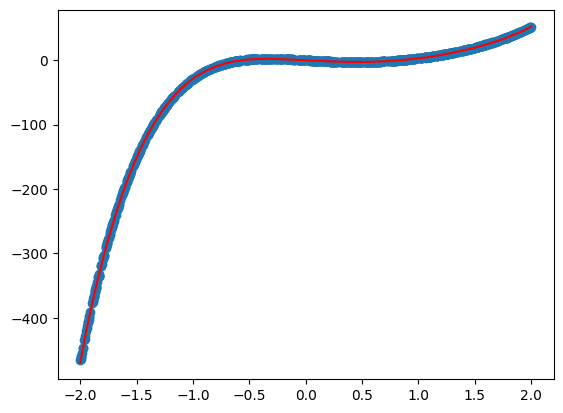

0.04943325424934619
0.001771324096095139


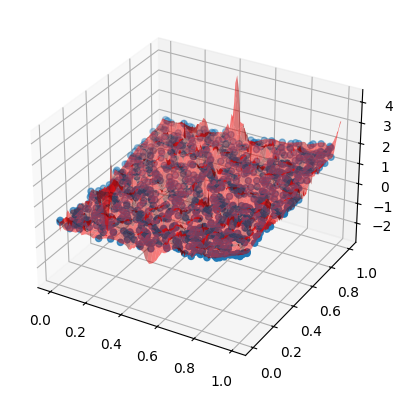

In [51]:
# generate a dataset using y = 3x^{5}-13x^{4}+23x^{3}-10x
# generate X values between -2 and 2

X = np.random.uniform(-2, 2, (1000, 1))
y = 3 * X[:, 0] ** 5 - 13 * X[:, 0] ** 4 + 23 * X[:, 0] ** 3 - 10 * X[:, 0] + np.random.normal(0, 0.1, 1000)

model = LocallyWeightedPolynomialRegression(tau=0.1, window_size=10, degree=5)

model.fit(X, y)

# plot the data and the line

plt.scatter(X[:, 0], y)

x_values = np.linspace(-2, 2, 100)

y_values = model.predict_gradient_descent(x_values.reshape(-1, 1))

plt.plot(x_values, y_values, color='red')

plt.show()

print(model.mse(X, y, gradient_descent=True))


# generate a polynomial y = x_1^2 + x_2^2

X = np.random.rand(1000, 2)
y = X[:, 0] ** 2 + X[:, 1] ** 2 + np.random.normal(0, 0.1, 1000)

model = LocallyWeightedPolynomialRegression(tau=0.1, window_size=10, degree=2)

model.fit(X, y)

print(model.mse(X, y, gradient_descent=False))

# plot using a 3D plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], y)

x1_values = np.linspace(0, 1, 100)

x2_values = np.linspace(0, 1, 100)

X1, X2 = np.meshgrid(x1_values, x2_values)

X = np.c_[X1.ravel(), X2.ravel()]

y_values = model.predict(X)

ax.plot_surface(X1, X2, y_values.reshape(100, 100), color='red', alpha=0.5)

plt.show()

# KNN Regression

The following implementation of KNN regression finds the K closest data points to the query point and averages the output values of those data points to make a prediction.

Auxillary functions include sum of squared error, mean squared error, and mean absolute error.

# Testing KNN Regression

The following code segment tests the KNN regression model on a generated dataset. Random data points are generated from a sin wave. Some noise is added to the data. The KNN regression model is then tested on the data.

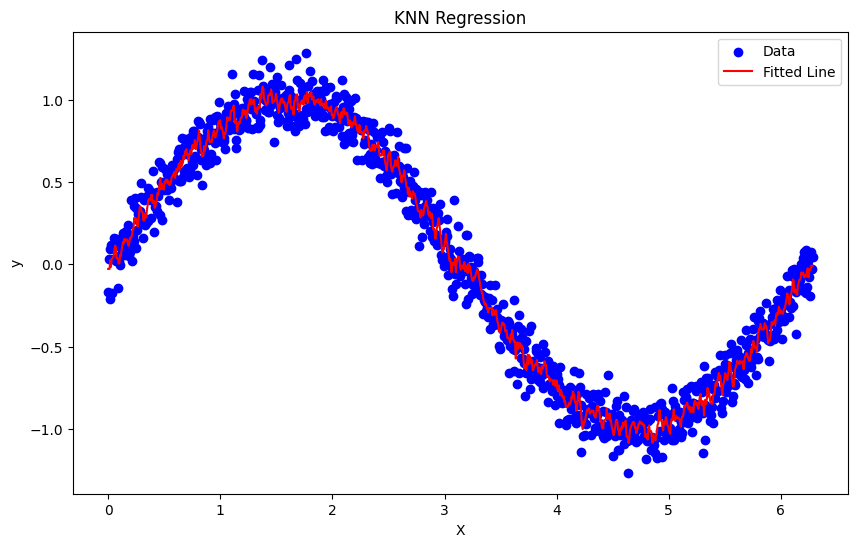

In [52]:
# implement KNN regeression

class KNNRegression:
    def __init__(self, k):
        # number of neighbors to consider
        self.k = k
        self.X = None
        self.y = None

    def fit(self, X, y):
        # store the training data
        self.X = X
        self.y = y

    def predict(self, X):
        y_pred = []
        # predict the value for each x in X
        for x in X:
            distances = np.linalg.norm(self.X - x, axis=1)
            nearest_indices = np.argsort(distances)[:self.k]
            y_pred.append(np.mean(self.y[nearest_indices]))
        return np.array(y_pred)
    
    # compute the sum of squared errors
    def compute_sse(self, X, y):
        y_pred = self.predict(X)
        return np.sum((y - y_pred) ** 2)
    
    # compute the mean squared error
    def compute_mse(self, X, y):
        return self.compute_sse(X, y) / X.shape[0]
    
    # compute the mean absolute error
    def compute_mae(self, X, y):
        y_pred = self.predict(X)
        return np.sum(np.abs(y - y_pred)) / X.shape[0]
    
# Generating data
X = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(X) + np.random.normal(0, 0.1, 1000)

X = X.reshape(-1, 1)
# Fitting the KNN regression model
model = KNNRegression(k=5)
model.fit(X, y)

# Predicting the values
y_pred = model.predict(X)

# Plotting the data and the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('KNN Regression')
plt.show()

# Decision Tree Regression

The following implementation of decision tree uses SSE as the criterion for splitting the data. The decision tree is built recursively. Some configurable parameters include the maximum depth of the tree, the minimum number of samples required to split a node, and max number of splits to consider

Tree nodes are stored as tuples, which have a feature index, threshold value, left pointer, and right pointer.

Auxillary functions include predict, sum of squared error, mean squared error, and mean absolute error.

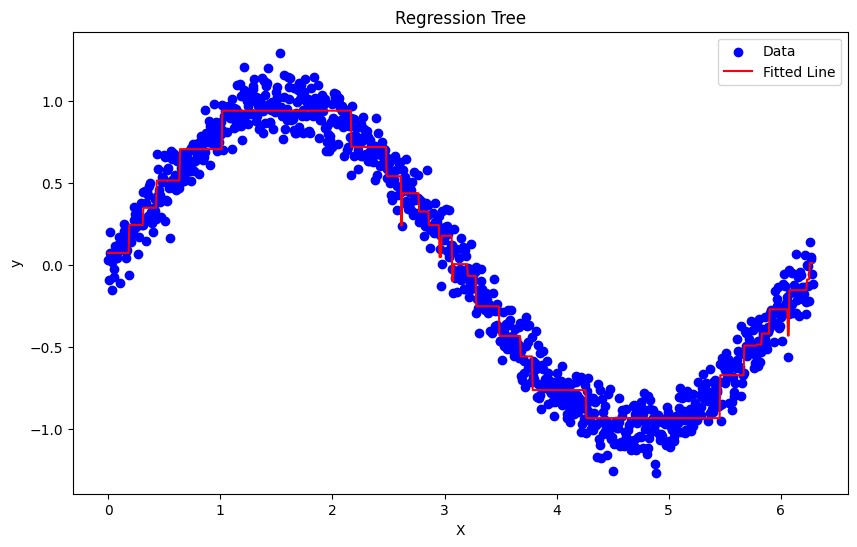

In [53]:
# implement regression tree
# Note: consider stopping conditions as small SSE, max depth, min samples per leaf

import math

class RegressionTree:
    def __init__(self, max_depth, min_samples_leaf, max_thresholds=50, min_sse=1):
        # store the hyperparameters
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.max_thresholds = max_thresholds
        self.min_sse = min_sse

    def fit(self, X, y):
        # recursively build the tree
        self.tree = self.build_tree(X, y, depth=0)

    def build_tree(self, X, y, depth):
        n_samples = X.shape[0]
        if n_samples >= self.min_samples_leaf and depth < self.max_depth:
            feature, threshold, sse = self.find_best_split(X, y)
            if not math.isinf(sse) and sse > self.min_sse:
                # split dataset based on threshold
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                # recursively build both sides of tree
                left_tree = self.build_tree(X[left_indices], y[left_indices], depth + 1)
                right_tree = self.build_tree(X[right_indices], y[right_indices], depth + 1)

                # construct node as a tuple
                return (feature, threshold, left_tree, right_tree)
            
        # return the leaf node
        return np.mean(y)

    def find_best_split(self, X, y):
        n_features = X.shape[1]
        
        # initialize variables to keep track of best split
        best_sse = float('inf')
        best_feature = None
        best_threshold = None

        # iterate through every feature
        for feature in range(n_features):
            # find unique values for the feature
            thresholds = np.unique(X[:, feature])
            
            if len(thresholds) > self.max_thresholds:
            # Obtain a random subset of thresholds if there are too many
                thresholds = np.percentile(thresholds, np.linspace(0, 100, self.max_thresholds))

            # iterate through every unique value
            for threshold in thresholds:
                # split the dataset based on the threshold
                left_indices = X[:, feature] < threshold
                right_indices = ~left_indices

                # if either side is empty, ignore this split
                if not np.any(left_indices) or not np.any(right_indices):
                    continue
                
                # compute the sse on both sides
                left_sse = np.sum((y[left_indices] - np.mean(y[left_indices])) ** 2)
                right_sse = np.sum((y[right_indices] - np.mean(y[right_indices])) ** 2)
                sse = left_sse + right_sse

                # update the best split if sse is lower
                if sse < best_sse:
                    best_sse = sse
                    best_feature = feature
                    best_threshold = threshold

        # return the best split
        return best_feature, best_threshold, best_sse

    # predict the output given the input
    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])

    # predict the output for a single sample
    def predict_sample(self, x, tree):
        if isinstance(tree, tuple):
            feature, threshold, left_tree, right_tree = tree
            if x[feature] < threshold:
                return self.predict_sample(x, left_tree)
            else:
                return self.predict_sample(x, right_tree)
            
        return tree
    
    # compute the sum of squared errors
    def compute_sse(self, X, y):
        y_pred = self.predict(X)
        return np.sum((y - y_pred) ** 2)

    # compute the mean squared error  
    def compute_mse(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y - y_pred) ** 2)

    # compute the mean absolute error
    def compute_mae(self, X, y):
        y_pred = self.predict(X)
        return np.mean(np.abs(y - y_pred))
    
# Generating data
X = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(X) + np.random.normal(0, 0.1, 1000)

X = X.reshape(-1, 1)
# Fitting the regression tree model
model = RegressionTree(max_depth=5, min_samples_leaf=10, min_sse=.00001)
model.fit(X, y)

# Predicting the values
y_pred = model.predict(X)

# Plotting the data and the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Regression Tree')
plt.show()


# Empirical Testing

Now, we run PCA and convert into test/train data. PCA should keep 95% of the variance and the train test split should be 80/20.

We will use 1000 random records from the original dataset in order to allow the model to converge in a reasonable amount of time.

Then, we will run the above models on the produced data.

In [86]:
import pandas as pd

df = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\features.csv")
y = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\labels.csv").to_numpy().flatten()

# implement PCA to see how many components are needed while maintaining 95% of the variance

# choose a random 100,000 samples, and their corresponding labels
df = df.sample(1000, random_state=42)
y = y[df.index]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# print number of components prior to pca
print(f"Number of features: {X_scaled.shape[1]}")

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {pca.n_components_}")

# split the data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Number of features: 68
Number of components: 48


In [ ]:
# call the custom linear regression model

model = MultiVariateLinearRegression()

model.fit(X_train, y_train)

print("Mean Squared Error:", model.compute_mse(X_test, y_test))

print("Mean Absolute Error:", model.compute_mae(X_test, y_test))

No improvement for 5 epochs. Stopping training.
Mean Squared Error: 170197.50144883507
Mean Absolute Error: 333.9092785633896


In [ ]:
# call the custom KNN regression model

model = KNNRegression(k=5)

model.fit(X_train, y_train)

print("Mean Squared Error:", model.compute_mse(X_test, y_test))

print("Mean Absolute Error:", model.compute_mae(X_test, y_test))


Mean Squared Error: 192408.7964
Mean Absolute Error: 351.376


In [ ]:
# call the custom regression tree model

model = RegressionTree(max_depth=5, min_samples_leaf=10, min_sse=.00001)

model.fit(X_train, y_train)

print("Mean Squared Error:", model.compute_mse(X_test, y_test))

print("Mean Absolute Error:", model.compute_mae(X_test, y_test))

Mean Squared Error: 245376.08866711176
Mean Absolute Error: 382.6926038243696


In [ ]:
# call the custom polynomial regression model

model = PolynomialRegression(degree=2)

model.fit_gradient_descent(X_train, y_train)

print("Mean Squared Error:", model.mse(X_test, y_test))

print("Mean Absolute Error:", model.mae(X_test, y_test))

No improvement for 5 epochs. Stopping training.
Mean Squared Error: 3.9044831998733937e+18
Mean Absolute Error: 722386199.2747405


In [ ]:
# call the custom polynomial regression model

model = PolynomialRegression(degree=2)

model.fit_gradient_descent(X_train, y_train, regularizer=Regularizer.L2)

print("Mean Squared Error", model.mse(X_test, y_test))

# compute mae

print("Mean Absolute Error", np.mean(np.abs(y_test - model.predict(X_test))))

No improvement for 5 epochs. Stopping training.
Mean Squared Error 6.130339622960483e+18
Mean Absolute Error 1069299067.4917166


In [ ]:
# call the locally weighted polynomial regression model

model = LocallyWeightedPolynomialRegression(tau=0.1, window_size=5, degree=2)

model.fit(X_pca, y)

print("Mean Squared Error", model.mse(X_pca, y, gradient_descent=True, optimizer=Optimizer.ADAM, regularizer=Regularizer.L2))

# compute mae

print("Mean Absolute Error", model.mae(X_pca, y, gradient_descent=True, optimizer=Optimizer.ADAM, regularizer=Regularizer.L2))

Mean Squared Error 530752.5034479903
Mean Absolute Error 377.1920329926077


# Graph Results

Now, we look at the graphs of the predicted values of the target variable against the actual values of the target variable for each of the models.

In the following examples, we only use a a random sample of 1000 data points from the test data to plot the graphs. If a particular model takes too long to converge, then we use a smaller subset of the data.

In [104]:
import pandas as pd

df = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\features.csv")
y = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\labels.csv").to_numpy().flatten()

# implement PCA to see how many components are needed while maintaining 95% of the variance

# choose a random 1,000 samples, and their corresponding labels
df = df.sample(1000)
y = y[df.index]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# print number of components prior to pca
print(f"Number of features: {X_scaled.shape[1]}")

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {pca.n_components_}")

# split the data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Number of features: 68
Number of components: 47


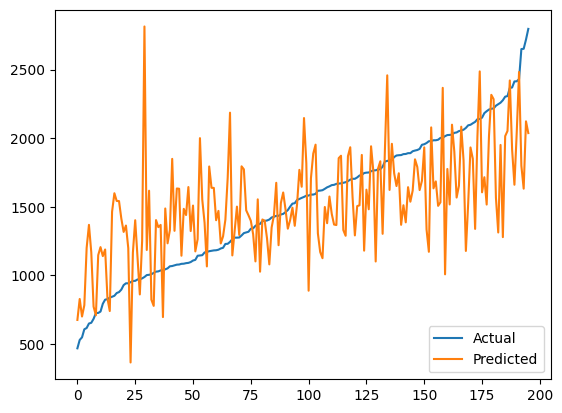

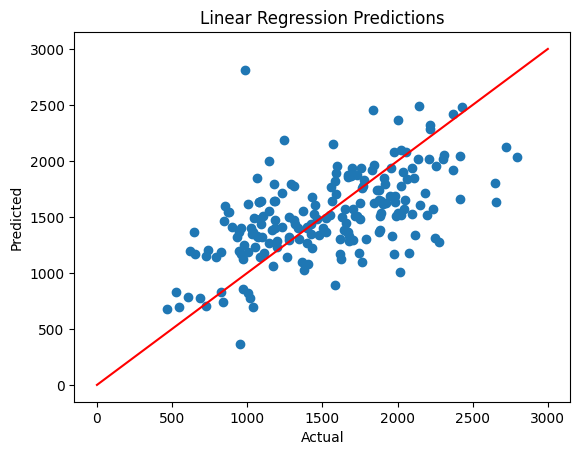

Mean Absolute Error: 329.7329860075683


In [55]:
import matplotlib.pyplot as plt

model = MultiVariateLinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# remove any outliers
y_test = y_test[(y_pred >= 0) & (y_pred <= 3000)]

y_pred = y_pred[(y_pred >= 0) & (y_pred <= 3000)]

# sort the y_test and y_pred values to plot them
sorted_indices = np.argsort(y_test)

plt.plot(np.arange(len(y_test)), y_test[sorted_indices], label='Actual')

plt.plot(np.arange(len(y_pred)), y_pred[sorted_indices], label='Predicted')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs actual values
plt.title("Linear Regression Predictions")
plt.scatter(y_test, y_pred)

plt.xlabel('Actual')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
print("Mean Absolute Error:", np.mean(np.abs(y_test - y_pred)))

No improvement for 5 epochs. Stopping training.


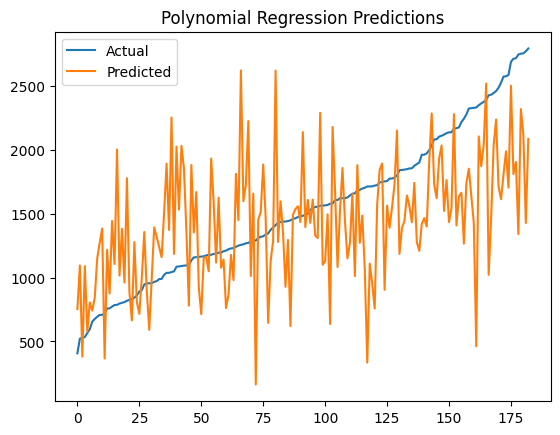

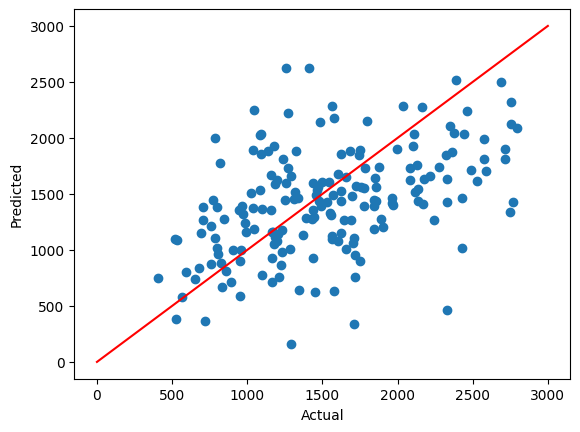

Mean Absolute Error: 442.39665201967784


In [114]:
# now try with polynomial regression

model = PolynomialRegression(degree=2)
model.epochs = 10000

model.fit_gradient_descent(X_train, y_train, regularizer=Regularizer.L2, optimizer=Optimizer.ADAM)

y_pred = model.predict(X_test)


# remove any outliers
y_test = y_test[(y_pred >= 0) & (y_pred <= 3000)]

y_pred = y_pred[(y_pred >= 0) & (y_pred <= 3000)]

# sort the y_test and y_pred values to plot them
sorted_indices = np.argsort(y_test)

plt.title("Polynomial Regression Predictions")

plt.plot(np.arange(len(y_test)), y_test[sorted_indices], label='Actual')

plt.plot(np.arange(len(y_pred)), y_pred[sorted_indices], label='Predicted')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs actual values

plt.scatter(y_test, y_pred)

plt.xlabel('Actual')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
print("Mean Absolute Error:", np.mean(np.abs(y_test - y_pred)))

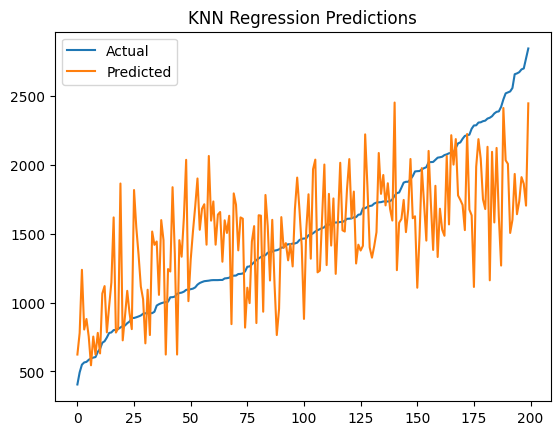

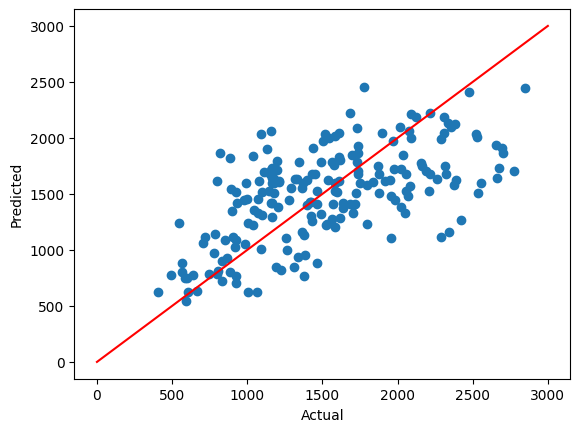

Mean Absolute Error: 362.34799999999996


In [69]:
# now try with KNN Regression

model = KNNRegression(k=5)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# remove any outliers
y_test = y_test[(y_pred >= 0) & (y_pred <= 3000)]

y_pred = y_pred[(y_pred >= 0) & (y_pred <= 3000)]

# sort the y_test and y_pred values to plot them
sorted_indices = np.argsort(y_test)

plt.title("KNN Regression Predictions")

plt.plot(np.arange(len(y_test)), y_test[sorted_indices], label='Actual')

plt.plot(np.arange(len(y_pred)), y_pred[sorted_indices], label='Predicted')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs actual values

plt.scatter(y_test, y_pred)

plt.xlabel('Actual')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
print("Mean Absolute Error:", np.mean(np.abs(y_test - y_pred)))

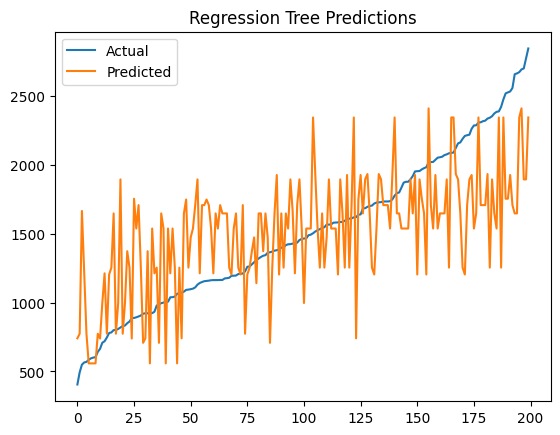

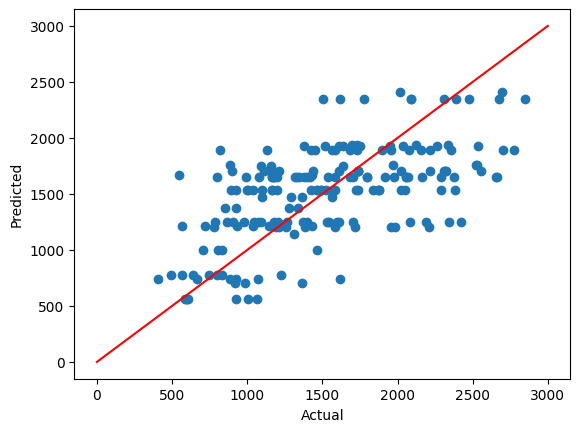

Mean Absolute Error: 364.9318423304272


In [70]:
# now try with regression tree

model = RegressionTree(max_depth=5, min_samples_leaf=10, min_sse=.00001)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# remove any outliers
y_test = y_test[(y_pred >= 0) & (y_pred <= 3000)]

y_pred = y_pred[(y_pred >= 0) & (y_pred <= 3000)]

# sort the y_test and y_pred values to plot them

sorted_indices = np.argsort(y_test)

plt.title("Regression Tree Predictions")

plt.plot(np.arange(len(y_test)), y_test[sorted_indices], label='Actual')

plt.plot(np.arange(len(y_pred)), y_pred[sorted_indices], label='Predicted')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs actual values

plt.scatter(y_test, y_pred)

plt.xlabel('Actual')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
print("Mean Absolute Error:", np.mean(np.abs(y_test - y_pred)))

In [74]:
# Locally weighted polynomial regression takes too long with 1000 records so recalculate dataset to only 100 records

df = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\features.csv")
y = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\labels.csv").to_numpy().flatten()

# implement PCA to see how many components are needed while maintaining 95% of the variance

# choose a random 1,000 samples, and their corresponding labels
df = df.sample(100)
y = y[df.index]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# print number of components prior to pca
print(f"Number of features: {X_scaled.shape[1]}")

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {pca.n_components_}")

# split the data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Number of features: 68
Number of components: 31


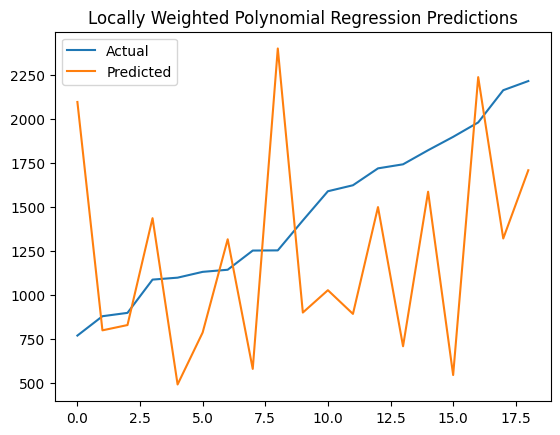

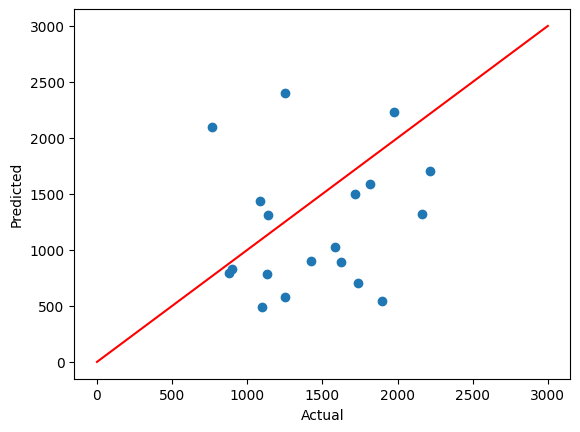

Mean Absolute Error: 580.7912380344106


In [79]:
# now try with locally weighted polynomial regression

model = LocallyWeightedPolynomialRegression(tau=0.1, window_size=5, degree=2)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# flatten the y_pred
y_pred = y_pred.flatten()

# remove any outliers
y_test = y_test[(y_pred >= 0) & (y_pred <= 3000)]

y_pred = y_pred[(y_pred >= 0) & (y_pred <= 3000)]

# sort the y_test and y_pred values to plot them
sorted_indices = np.argsort(y_test)

plt.title("Locally Weighted Polynomial Regression Predictions")

plt.plot(np.arange(len(y_test)), y_test[sorted_indices], label='Actual')

plt.plot(np.arange(len(y_pred)), y_pred[sorted_indices], label='Predicted')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs actual values

plt.scatter(y_test, y_pred)

plt.xlabel('Actual')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
print("Mean Absolute Error:", np.mean(np.abs(y_test - y_pred)))